In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
train_path = './archive/train.txt'
val_path = './archive/val.txt'
test_path = './archive/test.txt'

train_df = pd.read_csv(train_path, sep=';', names=['Text', 'Emotion'])
val_df = pd.read_csv(val_path, sep=';', names=['Text', 'Emotion'])
test_df = pd.read_csv(test_path, sep=';', names=['Text', 'Emotion'])

train_df = train_df.drop(train_df[(train_df['Emotion'] == 'surprise') | (train_df['Emotion'] == 'love')].index)
val_df = val_df.drop(val_df[(val_df['Emotion'] == 'surprise') | (val_df['Emotion'] == 'love')].index)
test_df = test_df.drop(test_df[(test_df['Emotion'] == 'surprise') | (test_df['Emotion'] == 'love')].index)

In [3]:
nltk.download('stopwords')
stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AugustHS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [4]:
vectorizer = CountVectorizer(max_features=5000, stop_words= stopwords.words('english'))
train_feature = vectorizer.fit_transform(train_df['Text']).toarray()
val_feature = vectorizer.transform(val_df['Text']).toarray()
test_feature = vectorizer.transform(test_df['Text']).toarray()

label_encoder = LabelEncoder()
train_label = label_encoder.fit_transform(train_df['Emotion'])
val_label = label_encoder.transform(val_df['Emotion'])
test_label = label_encoder.transform(test_df['Emotion'])

d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [5]:
class TextDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        labels = self.labels[idx]
        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        return features, labels

train_dataset = TextDataset(train_feature, train_label)
val_dataset = TextDataset(val_feature, val_label)
test_dataset = TextDataset(test_feature, test_label)

train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [6]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(32 * (input_dim // 4), 256)
        self.fc2 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

input_dim = train_feature.shape[1]
output_dim = len(label_encoder.classes_)

In [7]:
model = CNNModel(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

d:\anaconda3\envs\lab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CNNModel(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=40000, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [8]:
epochs = 50
train_losses = []
val_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0

    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        
        predictions = torch.argmax(outputs, dim=1)
        correct_train_predictions += torch.sum(predictions == labels)
        
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_predictions.double() / len(train_loader.dataset)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            predictions = torch.argmax(outputs, dim=1)
            correct_val_predictions += torch.sum(predictions == labels)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val_predictions.double() / len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/50, Training Loss: 1.0370, Training Accuracy: 0.5767, Validation Loss: 0.6010, Validation Accuracy: 0.8001
Epoch 2/50, Training Loss: 0.4934, Training Accuracy: 0.8269, Validation Loss: 0.4554, Validation Accuracy: 0.8403
Epoch 3/50, Training Loss: 0.2960, Training Accuracy: 0.9003, Validation Loss: 0.3903, Validation Accuracy: 0.8777
Epoch 4/50, Training Loss: 0.1898, Training Accuracy: 0.9360, Validation Loss: 0.3730, Validation Accuracy: 0.8874
Epoch 5/50, Training Loss: 0.1190, Training Accuracy: 0.9621, Validation Loss: 0.3606, Validation Accuracy: 0.8909
Epoch 6/50, Training Loss: 0.0889, Training Accuracy: 0.9698, Validation Loss: 0.3644, Validation Accuracy: 0.8966
Epoch 7/50, Training Loss: 0.0728, Training Accuracy: 0.9760, Validation Loss: 0.3988, Validation Accuracy: 0.8920
Epoch 8/50, Training Loss: 0.0681, Training Accuracy: 0.9777, Validation Loss: 0.4069, Validation Accuracy: 0.8932
Epoch 9/50, Training Loss: 0.0632, Training Accuracy: 0.9777, Validation Loss: 0

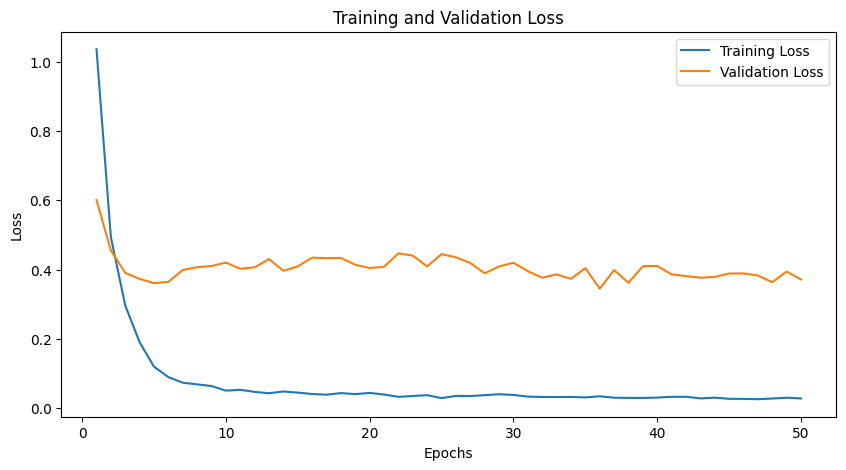

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [11]:
model.eval()
total_test_loss = 0
correct_predictions = 0
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct_predictions += torch.sum(predictions == labels)

avg_test_loss = total_test_loss / len(test_loader)
accuracy = correct_predictions.double() / len(test_loader.dataset)

print(f'Test Loss: {avg_test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Test Loss: 0.3704
Test Accuracy: 0.9166


In [12]:
torch.save(model.state_dict(), './Model_A.pth')